## Import library

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  

In [2]:
def get_available_gpus():
    """
    code from http://stackoverflow.com/questions/38559755/how-to-get-current-available-gpus-in-tensorflow
    """
    from tensorflow.python.client import device_lib as _device_lib
    local_device_protos = _device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [3]:
get_available_gpus()

[]

## Define path & total number

In [4]:
path = "C:/users/cs623/.keras/datasets/personal_cats_and_dogs"
path_cat = os.path.join(path, 'cats')
path_dog = os.path.join(path, 'dogs')

In [5]:
num_cats = len(os.listdir(path_cat))
num_dogs = len(os.listdir(path_dog))
total_img_num = num_cats + num_dogs
print('total cat images:', num_cats)
print('total dog images:', num_dogs)
print('total images:', total_img_num)

total cat images: 1500
total dog images: 2172
total images: 3672


## Train test split

In [6]:
batch_size = 200
epochs = 50
IMG_HEIGHT = 150
IMG_WIDTH = 150
split = 0.2
total_val = total_img_num * split
total_train = total_img_num - total_val

In [7]:
# Generator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=split)

#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,

In [8]:
# Load images from the disk, applies rescaling, and resizes the images

train_generator = train_datagen.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='validation') # set as validation data

Found 2938 images belonging to 2 classes.
Found 734 images belonging to 2 classes.


## Labels

In [9]:
import collections

def count_label(generator):
    l = len(generator)
    counter = collections.Counter()
    for i in range(l):
        _, label = generator[i]
        unique, counts = np.unique(label, return_counts=True)
        count_label = dict(zip(unique, counts))
        counter.update(count_label) 
    result = dict(counter)
    return result

In [10]:
train_count = count_label(train_generator)
val_count = count_label(validation_generator)

print("Training labels:")
print(train_count)
print("Validation labels:")
print(val_count)

Training labels:
{0.0: 1200, 1.0: 1738}
Validation labels:
{0.0: 300, 1.0: 434}


## Sample visualisation

In [11]:
sample_img_train, sample_label_train = next(train_generator)

In [12]:
def plotImg(img):
    fig, axes = plt.subplots(3, 5, figsize=(20, 20))
    axes = axes.flatten()
    for i, a in zip(img, axes):
        a.imshow(i)
        a.axis("off")
    plt.tight_layout()
    plt.show()

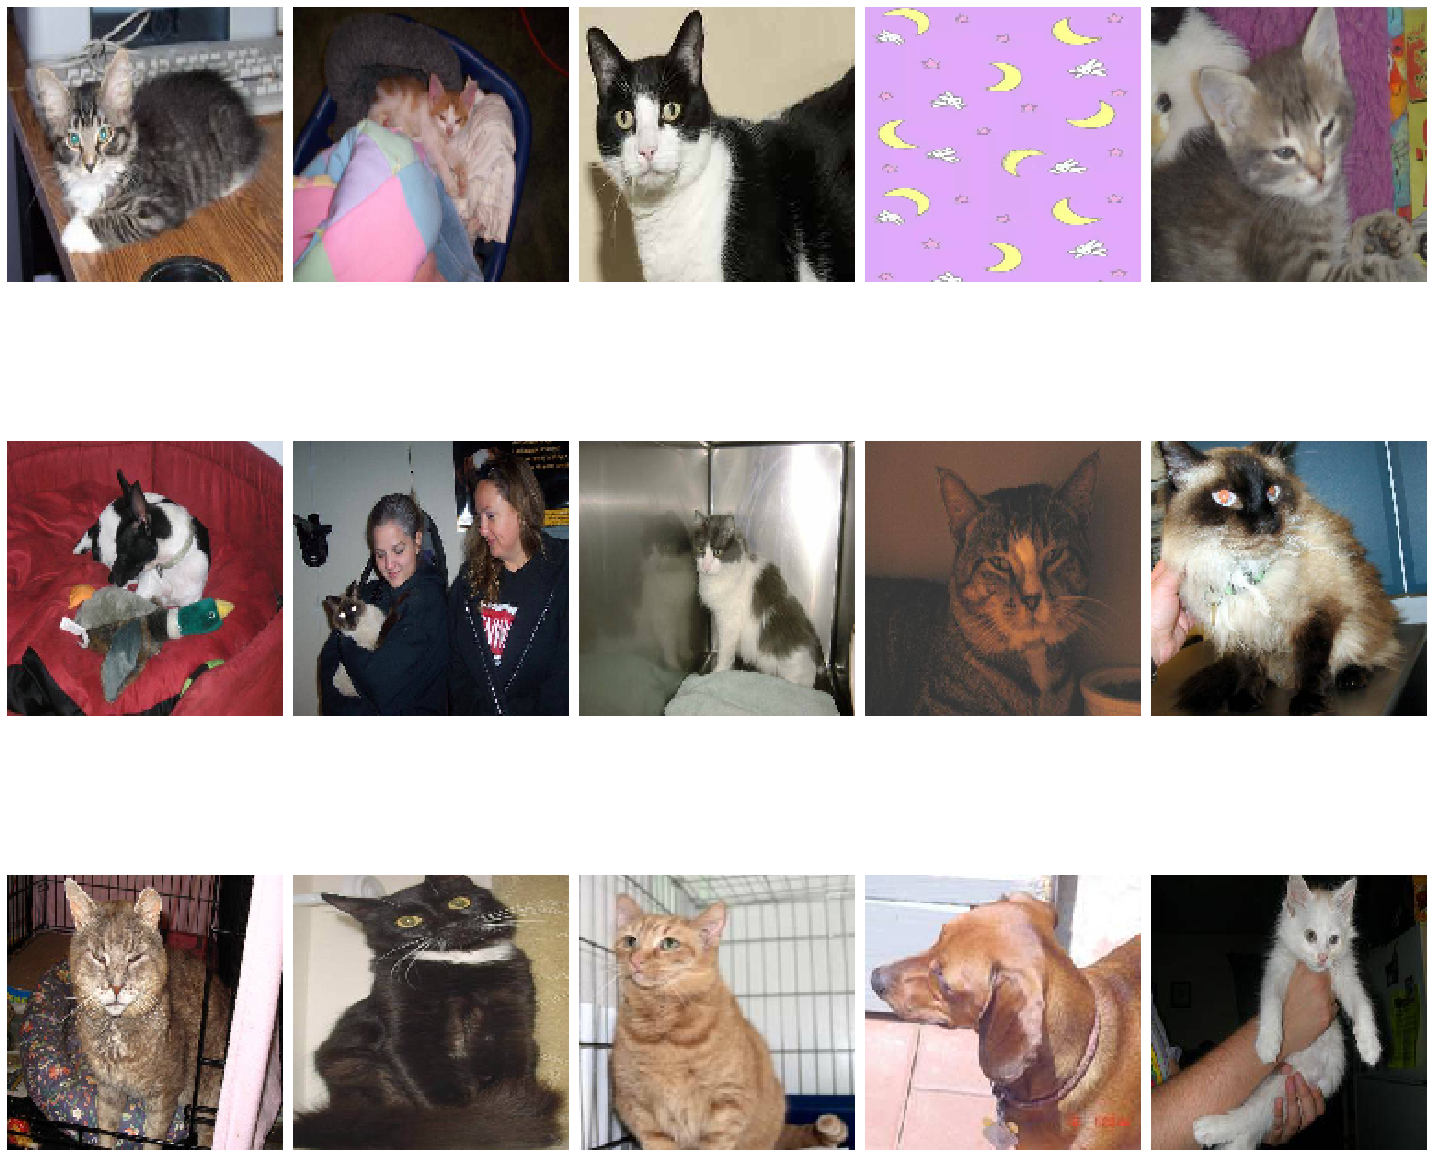

In [13]:
plotImg(sample_img_train[:15])

## Model

In [14]:
model = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(1000, activation='softmax'),
    Dense(1, activation='sigmoid')
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 256)       2

## Train model

In [17]:
with tf.device('/gpu:0'):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = total_train // batch_size,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = total_val // batch_size
    )

Epoch 1/50


InvalidArgumentError: Cannot assign a device for operation dense/bias/Initializer/zeros: Could not satisfy explicit device specification '' because the node node dense/bias/Initializer/zeros (defined at <ipython-input-14-82723d73c133>:25) placed on device Device assignments active during op 'dense/bias/Initializer/zeros' creation:
  with tf.device(None): <C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:602>  was colocated with a group of nodes that required incompatible device '/job:localhost/replica:0/task:0/device:GPU:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:CPU:0' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
Const: CPU 
ResourceApplyAdam: CPU 
Fill: CPU 
VarHandleOp: CPU 
AssignVariableOp: CPU 
VarIsInitializedOp: CPU 
ReadVariableOp: CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  dense/bias/Initializer/zeros/shape_as_tensor (Const) 
  dense/bias/Initializer/zeros/Const (Const) 
  dense/bias/Initializer/zeros (Fill) 
  dense/bias (VarHandleOp)  framework assigned device=/job:localhost/replica:0/task:0/device:CPU:0
  dense/bias/IsInitialized/VarIsInitializedOp (VarIsInitializedOp)  framework assigned device=/job:localhost/replica:0/task:0/device:CPU:0
  dense/bias/Assign (AssignVariableOp)  framework assigned device=/job:localhost/replica:0/task:0/device:CPU:0
  dense/bias/Read/ReadVariableOp (ReadVariableOp)  framework assigned device=/job:localhost/replica:0/task:0/device:CPU:0
  dense/BiasAdd/ReadVariableOp (ReadVariableOp)  framework assigned device=/job:localhost/replica:0/task:0/device:CPU:0
  VarIsInitializedOp_12 (VarIsInitializedOp) /device:GPU:0 framework assigned device=/job:localhost/replica:0/task:0/device:CPU:0
  Adam/dense/bias/m/Initializer/zeros/shape_as_tensor (Const) 
  Adam/dense/bias/m/Initializer/zeros/Const (Const) 
  Adam/dense/bias/m/Initializer/zeros (Fill) 
  Adam/dense/bias/m (VarHandleOp) /device:GPU:0
  Adam/dense/bias/m/IsInitialized/VarIsInitializedOp (VarIsInitializedOp) /device:GPU:0
  Adam/dense/bias/m/Assign (AssignVariableOp) /device:GPU:0
  Adam/dense/bias/m/Read/ReadVariableOp (ReadVariableOp) /device:GPU:0
  Adam/dense/bias/v/Initializer/zeros/shape_as_tensor (Const) 
  Adam/dense/bias/v/Initializer/zeros/Const (Const) 
  Adam/dense/bias/v/Initializer/zeros (Fill) 
  Adam/dense/bias/v (VarHandleOp) /device:GPU:0
  Adam/dense/bias/v/IsInitialized/VarIsInitializedOp (VarIsInitializedOp) /device:GPU:0
  Adam/dense/bias/v/Assign (AssignVariableOp) /device:GPU:0
  Adam/dense/bias/v/Read/ReadVariableOp (ReadVariableOp) /device:GPU:0
  Adam/Adam/update_dense/bias/ResourceApplyAdam (ResourceApplyAdam) /device:GPU:0
  VarIsInitializedOp_73 (VarIsInitializedOp) /device:GPU:0
  VarIsInitializedOp_82 (VarIsInitializedOp) /device:GPU:0

	 [[node dense/bias/Initializer/zeros (defined at <ipython-input-14-82723d73c133>:25) ]]Additional information about colocations:No node-device colocations were active during op 'dense/bias/Initializer/zeros' creation.
Device assignments active during op 'dense/bias/Initializer/zeros' creation:
  with tf.device(None): <C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:602>

Original stack trace for 'dense/bias/Initializer/zeros':
  File "C:\Users\cs623\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\cs623\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\cs623\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\cs623\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\cs623\Anaconda3\lib\asyncio\base_events.py", line 539, in run_forever
    self._run_once()
  File "C:\Users\cs623\Anaconda3\lib\asyncio\base_events.py", line 1775, in _run_once
    handle._run()
  File "C:\Users\cs623\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tornado\gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tornado\gen.py", line 714, in __init__
    self.run()
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\cs623\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-82723d73c133>", line 25, in <module>
    Dense(1, activation='sigmoid')
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py", line 110, in __init__
    self.add(layer)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py", line 192, in add
    output_tensor = layer(self.outputs[0])
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 591, in __call__
    self._maybe_build(inputs)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1881, in _maybe_build
    self.build(input_shapes)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\core.py", line 1026, in build
    trainable=True)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 384, in add_weight
    aggregation=aggregation)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\base.py", line 663, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_utils.py", line 155, in make_variable
    shape=variable_shape if variable_shape.rank else None)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2495, in default_variable_creator
    shape=shape)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 460, in __init__
    shape=shape)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 604, in _init_from_args
    initial_value() if init_from_fn else initial_value,
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_utils.py", line 135, in <lambda>
    init_val = lambda: initializer(shape, dtype=dtype)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py", line 114, in __call__
    return array_ops.zeros(shape, dtype)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1883, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3613, in fill
    "Fill", dims=dims, value=value, name=name)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Users\cs623\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


## Result visualisation 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()